# Кластеризация

# Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import torch
import math
from torch import Tensor
import torch.nn.functional as F
from typing import List
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import umap

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

test_dataset = pd.read_excel('tests_md.xlsx')

def prepare_df(df: pd.DataFrame) -> List[pd.DataFrame]:
    def remove_columns_step(dataset: pd.DataFrame) -> pd.DataFrame:
        output_dataset = dataset[
            ["Id", "Direction", "Section", "TestCaseName", "Preconditions", "Steps", "Postconditions",
                 "ExpectedResult"]].copy()
        output_dataset[["Id", "Direction", "Section", "TestCaseName"]] = output_dataset[
                ["Id", "Direction", "Section", "TestCaseName"]].ffill()
        
        return output_dataset

    output_first_step = remove_columns_step(df)

    def parse_tests_by_id(dataset: pd.DataFrame) -> List[pd.DataFrame]:
        test_cases = []
        for group_name, frame in dataset.groupby('Id'):
            test_cases.append(frame)

        return test_cases

    output_second_step = parse_tests_by_id(output_first_step)

    def remove_empty_cells(array: List[pd.DataFrame]) -> List[pd.DataFrame]:
        def up_cells(tst_case: pd.DataFrame, column: str) -> pd.DataFrame:
            for i in range(len(tst_case[column])):
                if i == len(tst_case.index) - 1:
                    tst_case.at[tst_case.index[i], column] = math.nan
                    break
                else:
                    tst_case.at[tst_case.index[i], column] = tst_case.at[tst_case.index[i + 1], column]

            return tst_case

        for dframe in array:
            for col in ["Preconditions", "Steps", "Postconditions", "ExpectedResult"]:
                dframe = up_cells(dframe, col)

            dframe["Steps"] = dframe["Steps"].fillna(dframe["Preconditions"])
            dframe["Steps"] = dframe["Steps"].fillna(dframe["Postconditions"])
            dframe.drop(["Preconditions", "Postconditions"], inplace=True, axis=1)

        return array

    output_third_step = remove_empty_cells(output_second_step)
    return output_third_step
    
    
prepared_df = prepare_df(test_dataset)
prepared_df[0]

Id   Direction                           Section  \
4   544009.0  AI_Отладка  1.1. Аутентификация пользователя   
5   544009.0  AI_Отладка  1.1. Аутентификация пользователя   
6   544009.0  AI_Отладка  1.1. Аутентификация пользователя   
7   544009.0  AI_Отладка  1.1. Аутентификация пользователя   
8   544009.0  AI_Отладка  1.1. Аутентификация пользователя   
9   544009.0  AI_Отладка  1.1. Аутентификация пользователя   
10  544009.0  AI_Отладка  1.1. Аутентификация пользователя   
11  544009.0  AI_Отладка  1.1. Аутентификация пользователя   
12  544009.0  AI_Отладка  1.1. Аутентификация пользователя   
13  544009.0  AI_Отладка  1.1. Аутентификация пользователя   
14  544009.0  AI_Отладка  1.1. Аутентификация пользователя   

               TestCaseName  \
4   Вход в систему ЕФР (GO)   
5   Вход в систему ЕФР (GO)   
6   Вход в систему ЕФР (GO)   
7   Вход в систему ЕФР (GO)   
8   Вход в систему ЕФР (GO)   
9   Вход в систему ЕФР (GO)   
10  Вход в систему ЕФР (GO)   
11  Вход в систему ЕФР (GO)   
12  Вход в систему ЕФР (GO)   
13  Вход в систему ЕФР (GO)   
14  Вход в систему ЕФР (GO)   

                                                Steps  \
4                                           lol kek 2   
5                                                hehe   
6                                               aboba   
7                                          Anton test   
8                                                 LOL   
9                        Открыта страница входа в ЕФР   
10  В поле "Домен" из выпадающего списка выбрать "GO"   
11           В поле "Логин" ввести логин пользователя   
12          В поле "АБОБА" ввести пароль пользователя   
13                              Нажать кнопку "Войти"   
14                                                NaN   

                                       ExpectedResult  
4                                          cheburek 2  
5                                               aboba  
6                                             lolol))  
7                                   Anton good answer  
8                                               ABOBA  
9                                                 NaN  
10              Выбранное значение сохраняется в поле  
11              Введенное значение сохраняется в поле  
12              Введенное значение сохраняется в поле  
13  Авторизация успешна. Открылась страница "Поиск...  
14                                                NaN

In [3]:
prepared_df[0].at[prepared_df[0].index[0], "Id"]

544009.0

In [4]:
prepared_df[0].at[prepared_df[0].index[0], "Direction"]

'AI_Отладка'

In [5]:
type(prepared_df[0]["Steps"].astype(str))

pandas.core.series.Series

In [6]:
type(prepared_df[0]["ExpectedResult"])

pandas.core.series.Series

In [7]:
(prepared_df[8]["ExpectedResult"])

75                                                kkkkk
76                                                  NaN
77                     тестовый ответ для замены что-то
78    Отображается страница входа в систему ЕФР, на ...
79    Вход осуществлен успешно. Отображается страниц...
80    Происходит переход в продуктовый профиль клиен...
81                                        TEST answer 1
82                                                  NaN
Name: ExpectedResult, dtype: object

In [8]:
str(prepared_df[0].at[prepared_df[0].index[0], "Direction"])

'AI_Отладка'

In [9]:
prepared_df[0].to_string("test_output_single_case.txt")

In [10]:
prepared_df[0].to_markdown("test_output_single_case.md")

In [11]:
prepared_df[0].to_clipboard()

In [12]:
str(math.nan)

'nan'

# Векторизация

In [13]:
def process_df(dataset: List[pd.DataFrame]) -> List[Tensor]:
    def mean_pooling(model_output, attention_mask) -> Tensor:
        token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1),
                                                                                      min=1e-9)
        
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
    model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
    mpnet_vectorized_output_array = []

    model.to(device)

    for test_case in dataset:
        # Tokenize
        encoded_input = tokenizer(str(test_case), return_tensors='pt', padding=True, truncation=True,
                                      max_length=512).to(device)
        # Compute token embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Perform pooling. In this case, average pooling
        embedding = mean_pooling(model_output, encoded_input['attention_mask'])
        mpnet_vectorized_output_array.append(F.normalize(embedding, p=2, dim=1))

    return mpnet_vectorized_output_array

mpnet_output_array = process_df(prepared_df)
mpnet_output_array[0]

tensor([[-1.7094e-02,  3.8856e-02, -7.6210e-03,  7.3982e-03,  6.8784e-02,
          3.2589e-02,  4.5039e-02,  4.0391e-02,  6.4674e-02,  6.7104e-02,
          1.3917e-02,  3.1914e-02,  3.9779e-02,  5.3925e-02, -1.7750e-03,
         -5.2750e-02,  2.9437e-02, -5.9025e-02, -3.7469e-02,  2.0657e-02,
          3.0559e-02, -1.8959e-02,  8.9638e-03,  1.2604e-03, -7.5469e-03,
         -1.1296e-02, -1.8868e-02, -5.8293e-03,  1.7034e-02,  7.3002e-03,
          4.9732e-04, -3.3431e-03,  1.3342e-02, -7.5276e-02,  7.5293e-03,
          1.0113e-02, -1.1526e-02,  6.0971e-03,  8.9643e-03,  1.7253e-02,
         -1.1248e-02, -5.6613e-02,  3.7995e-03,  1.1361e-02, -3.7648e-02,
         -7.0246e-02, -4.5181e-02,  6.5669e-02,  5.2943e-02,  3.6045e-02,
         -2.4661e-03, -3.9077e-03, -1.7744e-02,  1.5831e-02,  8.2537e-02,
         -7.4466e-02, -1.4033e-02,  1.1271e-02,  1.2750e-03, -3.3805e-02,
         -3.8175e-02, -1.1440e-02,  2.0563e-02, -1.5096e-02, -2.7607e-02,
          7.3789e-03,  1.0613e-02, -2.

# Снижение размерности

# UMAP

/home/paul/anaconda3/envs/EmbeddingTest/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_123154/783678092.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(compressed_umap_cluster_array[:, 0], compressed_umap_cluster_array[:, 1], cmap='viridis', s=100)


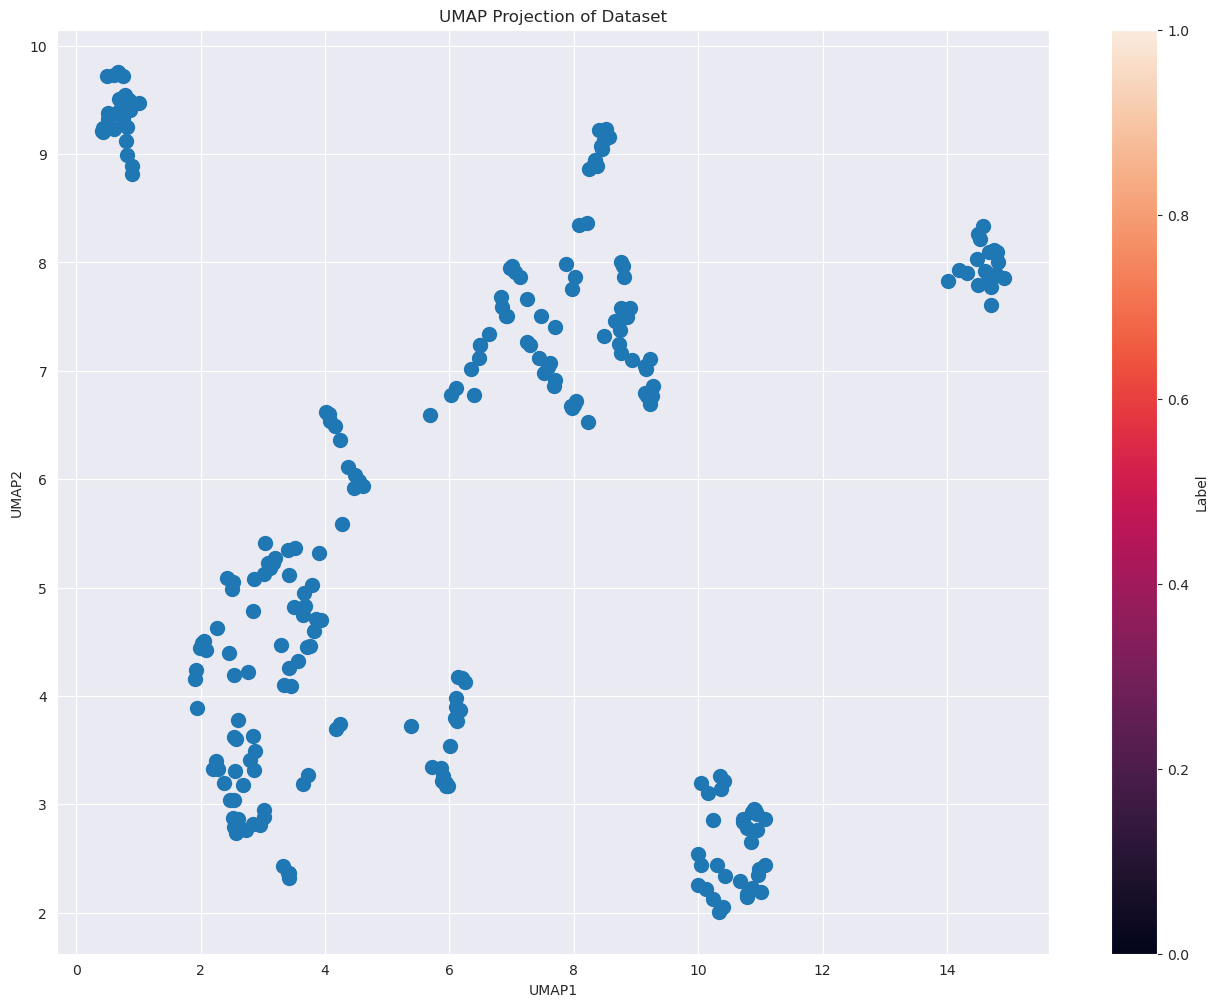

In [14]:
cluster_array = []
for t_outer in mpnet_output_array:
        for t_inner in t_outer:
            cluster_array.append(t_inner.cpu().numpy())

# Применение UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
compressed_umap_cluster_array = umap_model.fit_transform(cluster_array)

# Визуализация результата
plt.figure(figsize=(16, 12))
scatter = plt.scatter(compressed_umap_cluster_array[:, 0], compressed_umap_cluster_array[:, 1], cmap='viridis', s=100)
plt.title('UMAP Projection of Dataset')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(scatter, label='Label')
plt.show()

# K means

/home/paul/anaconda3/envs/EmbeddingTest/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


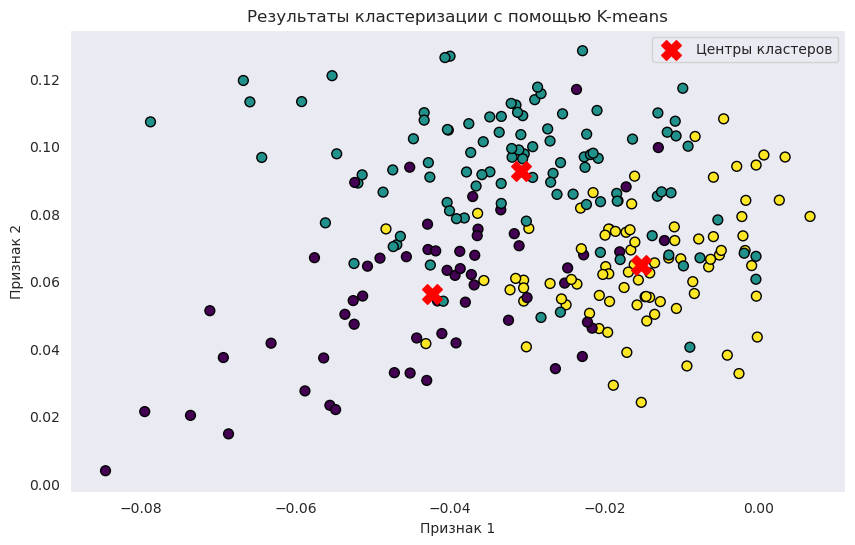

In [15]:
from sklearn.cluster import KMeans

cluster_array = np.array(cluster_array)
# Настройка K-means
n_clusters = 3  # Укажите количество кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Обучение K-means
kmeans.fit(cluster_array)

# Получите метки кластеров и центры
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(cluster_array[:, 0], cluster_array[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Центры кластеров')
plt.title('Результаты кластеризации с помощью K-means')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()
plt.grid()
plt.show()

# DBSCAN

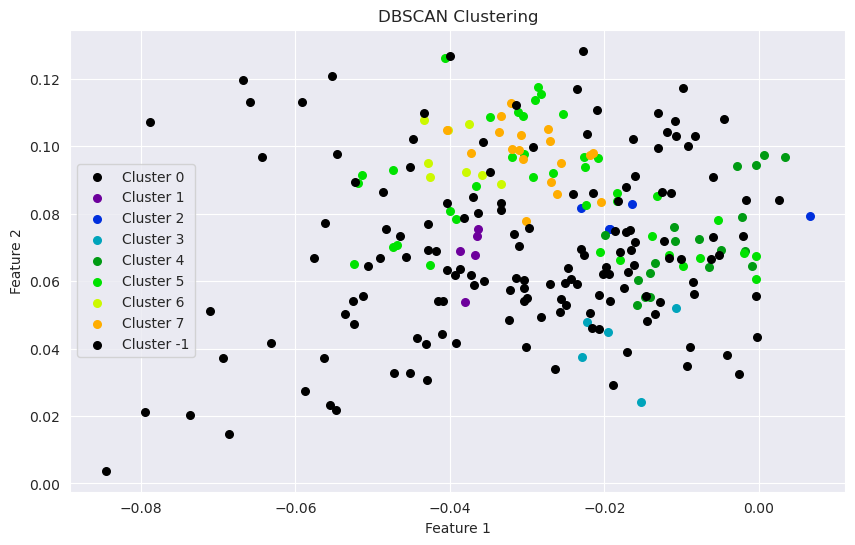

In [16]:
from sklearn.cluster import DBSCAN

epsilon = 0.3  # Радиус окрестности
min_samples = 5  # Минимальное количество точек для формирования кластера

# Применение DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(cluster_array)

# Визуализация результатов
plt.figure(figsize=(10, 6))

# Определение уникальных меток кластеров
unique_clusters = set(clusters)

for cluster in unique_clusters:
    # Определяем цвет для каждого кластера
    if cluster == -1:
        # Пограничные точки (шум)
        color = 'k'  # Чёрный цвет для шумовых точек
    else:
        color = plt.cm.nipy_spectral(float(cluster) / len(unique_clusters))  # Цвета для кластеров

    # Отображение точек
    plt.scatter(cluster_array[clusters == cluster, 0], cluster_array[clusters == cluster, 1], 
                s=30, color=color, label=f'Cluster {cluster}')
    
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [17]:
cluster_array

array([[-0.01709357,  0.03885598, -0.00762097, ...,  0.05505691,
        -0.05257676, -0.03361429],
       [-0.00032245,  0.0555306 , -0.00838997, ...,  0.07560504,
        -0.06170686, -0.04609961],
       [-0.00510758,  0.06772517, -0.00716964, ...,  0.05958375,
        -0.04626079, -0.03560539],
       ...,
       [-0.02928541,  0.09985537, -0.0083584 , ...,  0.05936306,
        -0.07940388, -0.04472408],
       [-0.03568669,  0.10132658, -0.00784862, ...,  0.05272726,
        -0.0723537 , -0.03807835],
       [-0.02703569,  0.10155053, -0.00803626, ...,  0.0610387 ,
        -0.06262535, -0.06365831]], dtype=float32)

In [18]:
type(cluster_array[0][0])

numpy.float32

In [19]:
test_output_first = []
for t_outer in mpnet_output_array:
        for t_inner in t_outer:
            test_output_first.append(t_inner.cpu().numpy())

test_output_second = []
for i in range(len(cluster_array)):
    test_output_second.append({"idx": i, "vector": cluster_array[i]})
    
test_output_second[0]

{'idx': 0,
 'vector': array([-1.70935728e-02,  3.88559811e-02, -7.62096653e-03,  7.39818672e-03,
         6.87839016e-02,  3.25894915e-02,  4.50385064e-02,  4.03909162e-02,
         6.46737590e-02,  6.71040043e-02,  1.39174815e-02,  3.19137275e-02,
         3.97792831e-02,  5.39249182e-02, -1.77501037e-03, -5.27503900e-02,
         2.94367746e-02, -5.90254180e-02, -3.74688692e-02,  2.06567384e-02,
         3.05589736e-02, -1.89585686e-02,  8.96383543e-03,  1.26044999e-03,
        -7.54686352e-03, -1.12961158e-02, -1.88683923e-02, -5.82932867e-03,
         1.70338601e-02,  7.30022136e-03,  4.97322239e-04, -3.34307272e-03,
         1.33424876e-02, -7.52763599e-02,  7.52927037e-03,  1.01132169e-02,
        -1.15261972e-02,  6.09706296e-03,  8.96430947e-03,  1.72528978e-02,
        -1.12476936e-02, -5.66128530e-02,  3.79949366e-03,  1.13605289e-02,
        -3.76480632e-02, -7.02456757e-02, -4.51807231e-02,  6.56693652e-02,
         5.29425368e-02,  3.60448323e-02, -2.46609678e-03, -3.90770

In [20]:
test_output_third = []
for vec in test_output_second:
    test_output_third.append(vec["vector"])
    
test_output_third

[array([-1.70935728e-02,  3.88559811e-02, -7.62096653e-03,  7.39818672e-03,
         6.87839016e-02,  3.25894915e-02,  4.50385064e-02,  4.03909162e-02,
         6.46737590e-02,  6.71040043e-02,  1.39174815e-02,  3.19137275e-02,
         3.97792831e-02,  5.39249182e-02, -1.77501037e-03, -5.27503900e-02,
         2.94367746e-02, -5.90254180e-02, -3.74688692e-02,  2.06567384e-02,
         3.05589736e-02, -1.89585686e-02,  8.96383543e-03,  1.26044999e-03,
        -7.54686352e-03, -1.12961158e-02, -1.88683923e-02, -5.82932867e-03,
         1.70338601e-02,  7.30022136e-03,  4.97322239e-04, -3.34307272e-03,
         1.33424876e-02, -7.52763599e-02,  7.52927037e-03,  1.01132169e-02,
        -1.15261972e-02,  6.09706296e-03,  8.96430947e-03,  1.72528978e-02,
        -1.12476936e-02, -5.66128530e-02,  3.79949366e-03,  1.13605289e-02,
        -3.76480632e-02, -7.02456757e-02, -4.51807231e-02,  6.56693652e-02,
         5.29425368e-02,  3.60448323e-02, -2.46609678e-03, -3.90770892e-03,
        -1.7